# Example 101 - Transfer Learning - Yosi

In [1]:
import numpy as np
import pandas as pd
from   keras.models import Sequential
from   keras.layers.core import Dense, Activation, Flatten
from   keras.optimizers import Adam
from   keras.callbacks import EarlyStopping
from   keras.preprocessing.image import ImageDataGenerator
from   keras.applications import VGG16
import matplotlib.pyplot as plt
from   time import time
%matplotlib inline

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
def PlotImages(ix_start, num_img, rows, cols, X, P, label_names):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    for i in range(num_img):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        plt.imshow(X[ix_start+i])
        plt.title(label_names[P[ix_start+i].argmax()] + ', ' + str(ix_start+i))

In [6]:
# setup preprocessing pipeline for training data
label_names = ['cat','dog']
batch_size = 2000
data_path = '/work/MA490_DeepLearning/Data/Dogs_vs_Cats/Small_Dataset/Train/'
DataGenerator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_path,
    target_size=(150,150),
    batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [7]:
# load training data in batches of size batch_size
(X,P) = DataGenerator.next()
print(X.shape)
print(P.shape)

(2000, 150, 150, 3)
(2000, 2)


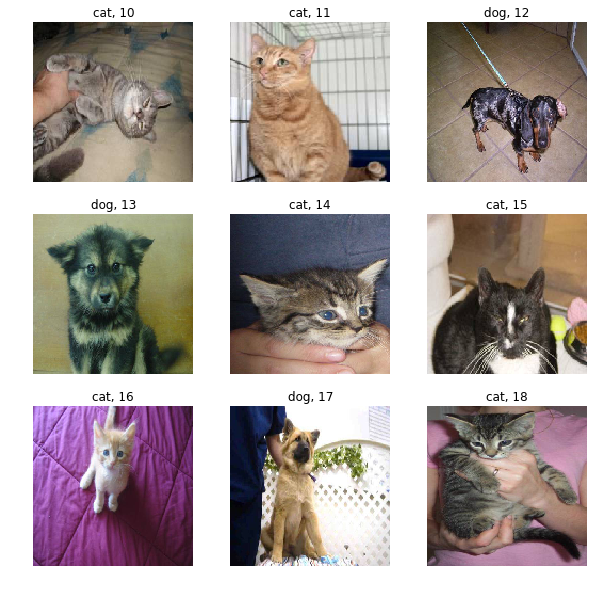

In [36]:
# plot some images
PlotImages(10,9,3,3,X,P,label_names)

In [9]:
# check balance and establish a baseline
acc_baseline = (P.sum(axis=0)/P.sum()).max()
print('baseline =',acc_baseline)

baseline = 0.5


In [12]:
# load validation data
label_names = ['cat','dog']
batch_size = 1000
data_path = '/work/MA490_DeepLearning/Data/Dogs_vs_Cats/Small_Dataset/Validation/'
ImageDataGeneratorObj = ImageDataGenerator(rescale=1./255)
DataGenerator = ImageDataGeneratorObj.flow_from_directory(
    data_path,
    target_size=(150,150),
    batch_size=batch_size)
(X_valid,P_valid) = DataGenerator.next()
print(X_valid.shape)
print(P_valid.shape)

Found 1000 images belonging to 2 classes.
(1000, 150, 150, 3)
(1000, 2)


In [13]:
# build VGG16
vgg16_base = VGG16(weights='imagenet',input_shape=(150,150,3),include_top=False)
vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [14]:
# extract VGG16 training features
X_features = vgg16_base.predict(X)
print('                   X shape:',X.shape)
print('          X_features shape:',X_features.shape)
X_features = np.reshape(X_features,(2000,4*4*512))
print('X_features shape flattened:',X_features.shape)

                   X shape: (2000, 150, 150, 3)
          X_features shape: (2000, 4, 4, 512)
X_features shape flattened: (2000, 8192)


elapsed time 0.0 min

minimum validation loss index 4 of 100
cross-entropy
        training = 0.14644424291327596
      validation = 0.5229205418407681
accuracy rate
        training = 0.9506250061094761
      validation = 0.9394147155269624
        baseline = 0.5


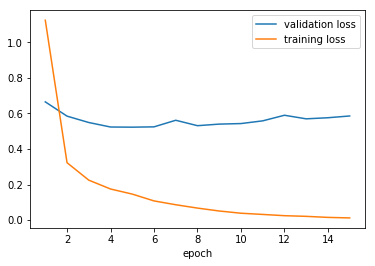

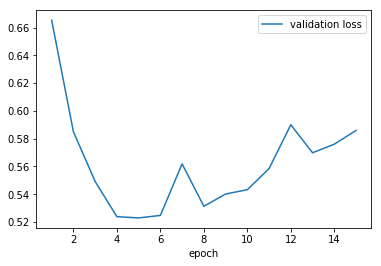

In [15]:
# run transfer training
epochs = 100
patience = 10

model = Sequential()
model.add(Dense(256,activation='relu',input_dim=4*4*512))
#model.add(layers.Dropout(0.5))
model.add(Dense(2,activation='softmax'))


model.compile(loss='categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy'])
time_start = time()
hist = model.fit(X_features,P,epochs=epochs,validation_split=0.2,verbose=0,
                 batch_size=100,
                callbacks=[EarlyStopping(patience=patience)])
#hist = model.fit(X_features,P,epochs=epochs,validation_data=(X_features_valid,P_valid),verbose=0,
#                 batch_size=100,
#                callbacks=[EarlyStopping(patience=patience)])
time_stop  = time()
time_elapsed = time_stop - time_start
results = pd.DataFrame()
results['epoch']           = hist.epoch
results['epoch']           = results['epoch'] + 1
results['training loss']   = hist.history['loss']
results['validation loss'] = np.sqrt(hist.history['val_loss'])
results['training acc']    = hist.history['acc']
results['validation acc']  = np.sqrt(hist.history['val_acc'])

ix = results['validation loss'].idxmin()
ce_training   = results['training loss'].iloc[ix]
ce_validation = results['validation loss'].iloc[ix]
acc_training   = results['training acc'].iloc[ix]
acc_validation = results['validation acc'].iloc[ix]
print('elapsed time',np.round(time_elapsed/60),'min')
print()
print('minimum validation loss index',ix,'of',epochs)
print('cross-entropy')
print('        training =',ce_training)
print('      validation =',ce_validation)
print('accuracy rate')
print('        training =',acc_training)
print('      validation =',acc_validation)
print('        baseline =',acc_baseline)

ax = results.plot.line(x='epoch',y='validation loss')
results.plot.line(x='epoch',y='training loss',ax=ax)
results.plot.line(x='epoch',y='validation loss')

In [17]:
# load test data
label_names = ['cat','dog']
batch_size = 1000
data_path = '/work/MA490_DeepLearning/Data/Dogs_vs_Cats/Small_Dataset/Test/'
ImageDataGeneratorObj = ImageDataGenerator(rescale=1./255)
DataGenerator = ImageDataGeneratorObj.flow_from_directory(
    data_path,
    target_size=(150,150),
    batch_size=batch_size)
(X_test,P_test) = DataGenerator.next()
print(X_test.shape)
print(P_test.shape)

Found 1000 images belonging to 2 classes.
(1000, 150, 150, 3)
(1000, 2)


In [18]:
# compute test error rate
X_features_test = vgg16_base.predict(X_test)
X_features_test = np.reshape(X_features_test,(1000,4*4*512))
Ph_test = model.predict(X_features_test)
ix_err = (Ph_test.argmax(axis=1) != P_test.argmax(axis=1))
X_err = X_test[ix_err]
P_err = P_test[ix_err]
acc_test = 1 - X_err.shape[0]/X_test.shape[0]
print('test accuracy rate =',acc_test)
print('number incorrect predictions',X_err.shape[0])

test accuracy rate = 0.88
number incorrect predictions 120


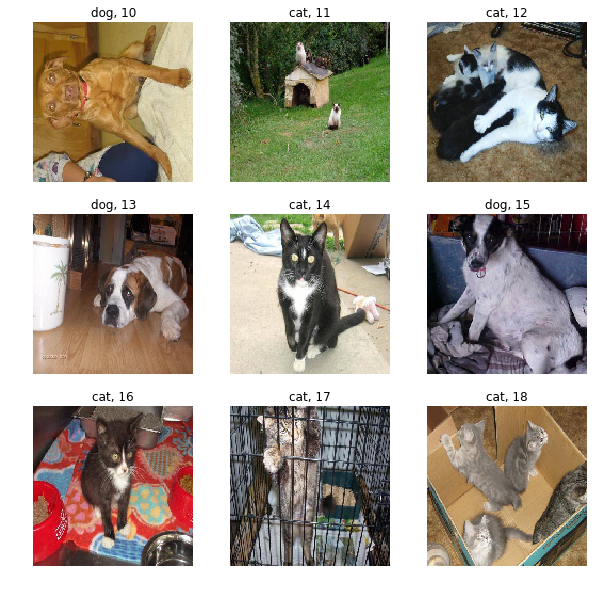

In [39]:
# plot incorrectly classified images
PlotImages(10, 9, 3, 3, X_err, P_err, label_names)